Experiment 3:
Timestep of 24 steps

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Loading necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon

from tensorflow.keras.layers import UpSampling2D
from numpy.lib.stride_tricks import as_strided
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler

import warnings

# Ignore warnings
warnings.filterwarnings('ignore')
np.set_printoptions(threshold=np.inf, precision=2, linewidth=200)
np.set_printoptions(suppress=True, precision=2)

As a first step, we load the raw data from our source.

In [6]:
# Defining the source path
route_folder = "/content/drive/My Drive/Centro de Transporte/Francisco/2023/Abril 2024/"

# Loading the data
data = df=pd.read_csv(route_folder+"datos_brutos.csv", sep=';')
# Date formatting
data['fecha_hora'] = pd.to_datetime(data['fecha_hora'])
data = data.sort_values('fecha_hora')

Let's visualize a brief sample of our raw data.

In [7]:
data.head()

,id,fecha_hora,lat,lon,velocidad,dir,cod_vehiculo
349447,1,2020-01-04 00:00:02,-33.462420,-70.777440,0,42,333
306071,2,2020-01-04 00:00:05,-33.458590,-70.782410,0,104,227
2926709,3,2020-01-04 00:00:11,-33.465040,-70.701230,32,191,448
4014577,4,2020-01-04 00:00:13,-33.610369,-70.701503,0,109,514
2946060,5,2020-01-04 00:00:17,-33.504414,-70.793083,0,256,379


As we can see, our data is structured as geospatial data, where we have a column with the date and time, latitude, and longitude of a speed measurement. This data was recorded by GPS on cargo vehicles in the metropolitan region.

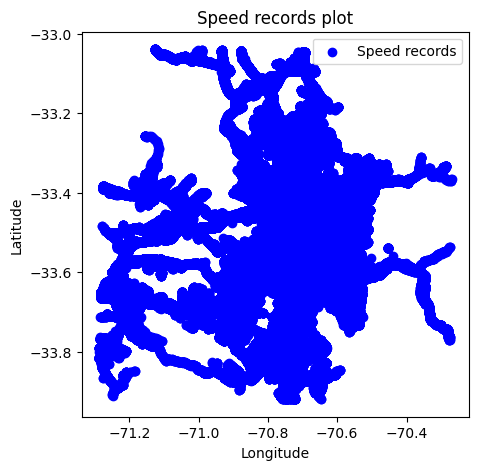

In [8]:
plt.figure(figsize=(5, 5))
plt.scatter(data['lon'], data['lat'], c='blue', label='Speed records')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Speed records plot')
plt.legend()
plt.show()

Next, we will narrow down the measurement field to a specific subregion

In [9]:
selected_data = data.copy()

df_1 = selected_data[(selected_data['lat'] >= -33.4331)].index
df_2 = selected_data[(selected_data['lat'] <= -33.4524)].index

selected_data.drop(df_1 , inplace=True)
selected_data.drop(df_2 , inplace=True)

df_3 = selected_data[(selected_data['lon'] >= -70.6253)].index
df_4 = selected_data[(selected_data['lon'] <= -70.6655)].index

selected_data.drop(df_3 , inplace=True)
selected_data.drop(df_4 , inplace=True)

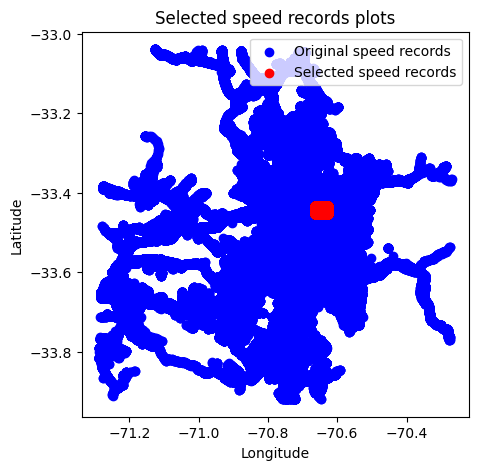

In [10]:
plt.figure(figsize=(5, 5))
plt.scatter(data['lon'], data['lat'], color='blue', label='Original speed records')
plt.scatter(selected_data['lon'], selected_data['lat'], color='red', label='Selected speed records')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Selected speed records plots')
plt.legend()
plt.show()

Next, we will perform some formatting, restructuring, and cleaning on our data.

In [11]:
# Removing records equal to zero
selected_data = selected_data[selected_data['velocidad'] != 0]

# Creating new columns for year, month, day, and hour
selected_data['year'] = selected_data['fecha_hora'].dt.year
selected_data['month'] = selected_data['fecha_hora'].dt.month
selected_data['day'] = selected_data['fecha_hora'].dt.day
selected_data['week_day'] = selected_data['fecha_hora'].dt.strftime('%A')
selected_data['hour'] = selected_data['fecha_hora'].dt.hour

# Sort by datetime
selected_data = selected_data.sort_values(by='fecha_hora')

# Rename, Deletion and ordering
selected_data.rename(columns={'fecha_hora': 'datetime'}, inplace=True)
selected_data.rename(columns={'velocidad': 'speed'}, inplace=True)

col_del = ['id', 'dir', 'cod_vehiculo']
selected_data = selected_data.drop(columns=col_del)

col_sort = ['datetime', 'year', 'month', 'day', 'week_day', 'hour', 'lat', 'lon','speed']
selected_data = selected_data[col_sort]

Let's take a quick look at how our data is now.

In [12]:
print(selected_data.shape)
selected_data.head()

(227397, 9)


,datetime,year,month,day,week_day,hour,lat,lon,speed
4288893,2020-01-04 04:45:06,2020,1,4,Saturday,4,-33.44956,-70.65487,37
4692717,2020-01-04 04:47:06,2020,1,4,Saturday,4,-33.44487,-70.65588,29
6616940,2020-01-04 04:48:06,2020,1,4,Saturday,4,-33.44573,-70.65967,45
181882,2020-01-04 06:34:01,2020,1,4,Saturday,6,-33.43661,-70.66046,60
164396,2020-01-04 06:35:01,2020,1,4,Saturday,6,-33.44075,-70.66025,21


Let's take a look at some plots.

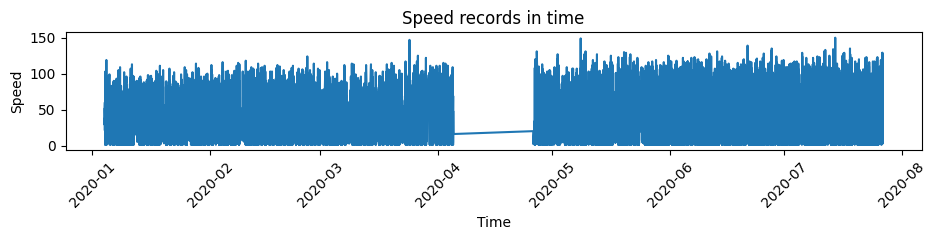

In [13]:
plt.figure(figsize=(9.5, 2.5))
plt.plot(selected_data['datetime'], selected_data['speed'])
plt.xlabel('Time')
plt.ylabel('Speed')
plt.title('Speed records in time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

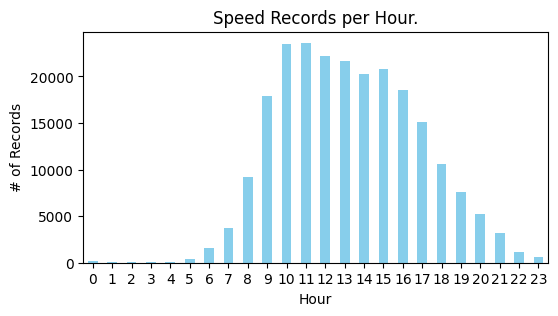

In [14]:
hourly_counts = selected_data.groupby('hour')['speed'].count()

plt.figure(figsize=(6, 3))
hourly_counts.plot(kind='bar', color='skyblue')
plt.title('Speed Records per Hour.')
plt.xlabel('Hour')
plt.ylabel('# of Records')
plt.xticks(rotation=0)
plt.show()

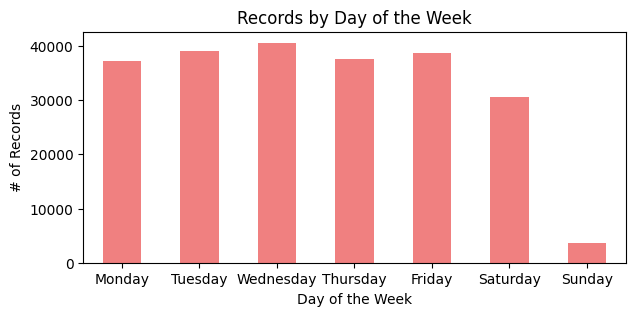

In [15]:
# Records by day of the week plot
week_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
selected_data['week_day'] = pd.Categorical(selected_data['week_day'], categories=week_days, ordered=True)
day_of_week_counts = selected_data.groupby('week_day')['speed'].count()

plt.figure(figsize=(7, 3))
day_of_week_counts.plot(kind='bar', color='lightcoral')
plt.xlabel('Day of the Week')
plt.ylabel('# of Records')
plt.title('Records by Day of the Week')
plt.xticks(rotation=0)
plt.show()

We will select only the range from 8:00 a.m. to 7:00 p.m., and additionally, we will exclude Sundays

In [16]:
# Removing hours that don't belong to the desired range
hours_del = [0, 1, 2, 3, 4, 5, 6, 7, 20, 21, 22, 23]
selected_data = selected_data[~selected_data['hour'].isin(hours_del)]
selected_data = selected_data[selected_data['week_day'] != 'Sunday']

Now that we have selected, reorganized, formatted, and cleaned our data, let's transform our geospatial data into hexagons.

In [17]:
# First, we install and import the Uber H3 library to hexagonalize our data.
!pip install h3==4.0.0b2 --quiet
!pip show h3
import h3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.8/931.8 kB 11.6 MB/s eta 0:00:00
Name: h3
Version: 4.0.0b2
Summary: Hierarchical hexagonal geospatial indexing system
Home-page: https://github.com/uber/h3-py
Author: Uber Technologies
Author-email: AJ Friend <ajfriend@gmail.com>
License: Apache 2.0 License
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: 


In [18]:
RES = 9 # Resolution parameter, more info at -> https://h3geo.org/docs/core-library/restable
selected_data['h3'] = selected_data.apply(lambda x: h3.latlng_to_cell(x.lat, x.lon, RES), axis=1)

H3 generates an H3 cell, which corresponds to a unique identifier representing a hexagon. Let's take a look.

In [19]:
hex_df = selected_data.copy()
hex_df.head()

,datetime,year,month,day,week_day,hour,lat,lon,speed,h3
2568261,2020-01-04 08:02:13,2020,1,4,Saturday,8,-33.451763,-70.633251,11,89b2c554c0fffff
741187,2020-01-04 08:02:56,2020,1,4,Saturday,8,-33.452186,-70.660449,10,89b2c554ed7ffff
3974100,2020-01-04 08:03:13,2020,1,4,Saturday,8,-33.448176,-70.634364,32,89b2c554c03ffff
3191535,2020-01-04 08:04:13,2020,1,4,Saturday,8,-33.444420,-70.633182,63,89b2c554c13ffff
3737979,2020-01-04 08:05:13,2020,1,4,Saturday,8,-33.437349,-70.635099,7,89b2c556a67ffff


In [20]:
n_hexagons = len(hex_df.h3.unique())
print(f'Amount of generated hexagons: {n_hexagons}')

Amount of generated hexagons: 110


Next, we will obtain coordinates so that instead of identifying the hexagons by the generated ID h3, they will be represented with coordinates $(i, j)$.

In [21]:
unique_hex_ids = hex_df['h3'].unique()

# Select a reference index. We will use the first index from the list.
reference_hex_id = unique_hex_ids[0]

# 1. Generate coordinates and store them in a dictionary
dict_ij = {}
for hex_id in unique_hex_ids:
    # Convert the ID to i, j coordinates
    coordinates = h3.cell_to_local_ij(reference_hex_id, hex_id)
    dict_ij[hex_id] = coordinates
    #print(f"{hex_id} => {dict_ij[hex_id]}")

# 2. Rescale the coordinates and save them in a new dictionary.
min_i = min([dict_ij[h][0] for h in dict_ij])
min_j = min([dict_ij[h][1] for h in dict_ij])

max_i = max([dict_ij[h][0] for h in dict_ij])
max_j = max([dict_ij[h][1] for h in dict_ij])

dict_ij_rescaled = {}
for hex_id in dict_ij:
    dict_ij_rescaled[hex_id] = [dict_ij[hex_id][0] - min_i, dict_ij[hex_id][1] - min_j]
    # print(dict_ij[hex_id], "=>", dict_ij_rescaled[hex_id])

def get_i_from_dict(h3_id):
    if h3_id in dict_ij_rescaled:
        return dict_ij_rescaled[h3_id][0]
    return None

hex_df['i'] = hex_df['h3'].map(get_i_from_dict)

def get_j_from_dict(h3_id):
    if h3_id in dict_ij_rescaled:
        return dict_ij_rescaled[h3_id][1]
    return None

hex_df['j'] = hex_df['h3'].map(get_j_from_dict)

Let's visualize a brief sample of the generated $(i, j)$ coordinates.

In [22]:
hex_df.head()

,datetime,year,month,day,week_day,hour,lat,lon,speed,h3,i,j
2568261,2020-01-04 08:02:13,2020,1,4,Saturday,8,-33.451763,-70.633251,11,89b2c554c0fffff,2,3
741187,2020-01-04 08:02:56,2020,1,4,Saturday,8,-33.452186,-70.660449,10,89b2c554ed7ffff,6,11
3974100,2020-01-04 08:03:13,2020,1,4,Saturday,8,-33.448176,-70.634364,32,89b2c554c03ffff,3,3
3191535,2020-01-04 08:04:13,2020,1,4,Saturday,8,-33.444420,-70.633182,63,89b2c554c13ffff,4,3
3737979,2020-01-04 08:05:13,2020,1,4,Saturday,8,-33.437349,-70.635099,7,89b2c556a67ffff,7,3


Verify that there are 110 generated coordinates (as well as the number of hexagons).

In [23]:
unique_coords_df = hex_df[['i', 'j']].drop_duplicates()
print(f"There are {len(unique_coords_df)} unique (i, j) coordinates.")

There are 110 unique (i, j) coordinates.


Let's plot the hexagons with their respective coordinates.

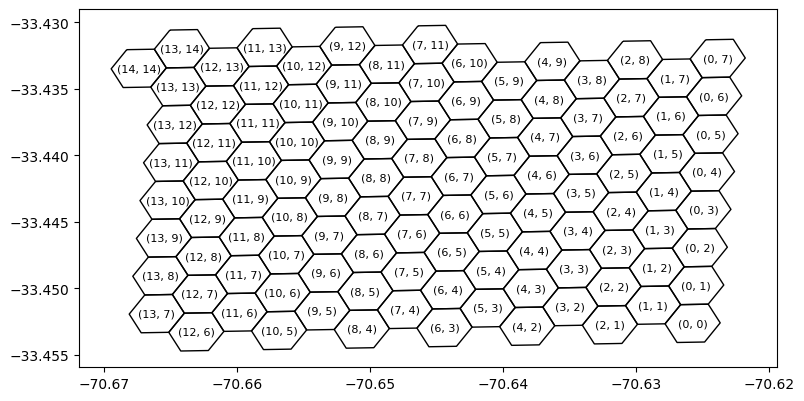

In [24]:
hex_df_geom = hex_df.copy()
# Converting H3 identifiers into polygons
hex_df_geom['geometry'] = hex_df_geom['h3'].apply(lambda x:Polygon(h3.cell_to_boundary(h=x, geo_json=True)))

gdf = gpd.GeoDataFrame(hex_df_geom.drop_duplicates(subset=['i', 'j']), geometry='geometry')
fig, ax = plt.subplots(figsize=(9, 9))

# Drawing the hexagons
gdf.plot(ax=ax, edgecolor='black', facecolor='none')

# Adding the (i, j) coordinates to each hexagon.
for x, y, i, j in zip(gdf.geometry.centroid.x, gdf.geometry.centroid.y, gdf['i'], gdf['j']):
    coord_text = f"({j}, {i})"
    ax.text(x, y, coord_text, horizontalalignment='center', verticalalignment='center', fontsize=8)

ax.set_title("")
plt.show()

Now that we have our hexagons represented by a pair of coordinates $(i, j)$, let's group each of them by the average speed according to the date and time.

In [25]:
# First, we get rid of the columns we no longer need
hex_df = hex_df.drop(columns=['year','month','day','week_day','lat','lon', 'h3'])

hex_df['date'] = hex_df['datetime'].dt.date
hex_df['hour'] = hex_df['datetime'].dt.hour

# Grouping averages by coordinates, date, and time
avg_df = hex_df.groupby(['date', 'hour', 'i', 'j']).speed.mean().reset_index()

# Adjusting the result
avg_df['datetime_id'] = pd.to_datetime(avg_df['date']) + pd.to_timedelta(avg_df['hour'], unit='h')
avg_df['datetime_id'] = avg_df['datetime_id'].dt.strftime('%Y-%m-%d %H')
avg_df = avg_df.drop(columns=['date','hour'])

In [26]:
print(avg_df.shape)
avg_df.head()

(94114, 4)


,i,j,speed,datetime_id
0,0,0,33.0,2020-01-04 08
1,1,2,6.0,2020-01-04 08
2,2,1,31.0,2020-01-04 08
3,2,2,48.0,2020-01-04 08
4,2,3,9.5,2020-01-04 08


At this point, we have reorganized our data into 4 columns: i, j, average speed, and a date and time identifier, where the day is represented by a number ranging from 08 to 19 representing the hour (from 8:00 a.m. to 7:00 p.m.).

Let's check how many time steps our data is composed of:

In [27]:
uniques = avg_df['datetime_id'].nunique()
print(f"We have {uniques} time steps")

We have 1880 time steps


As we can see, we have 1880 time steps, each of these time steps is composed of a grid of 110 coordinates where each position contains an average speed value.

However, we need to ensure the integrity of the time series, as we know there are steps when no data was recorded. To address this, we first need to find out which steps had no data recorded.

In [28]:
# We create a DataFrame with all possible combinations of date and time between
# the measurement periods to later merge it with avg_df and discover which days had no records.

dates = pd.date_range(start='2020-01-04', end='2020-07-26')
hours = range(8, 20)
merge = [(date, hour) for date in dates for hour in hours]
merged_df = pd.DataFrame(merge, columns=['date', 'hour'])

# Removing sundays
merged_df = merged_df[merged_df['date'].dt.dayofweek != 6]

# Generating the datetime_id column
merged_df['datetime_id'] = merged_df.apply(lambda row: row['date'].strftime('%Y-%m-%d') + ' ' + str(row['hour']).zfill(2), axis=1)

# Drop previous date and hour columns
merged_df = merged_df.drop(columns=['date', 'hour'])

# Merging
merged_df = pd.merge(merged_df, avg_df, on=['datetime_id'], how='left')

# Identify the rows where the speed is NaN (missing speed)
missing_speed = merged_df[merged_df['speed'].isna()]
missing_speed = missing_speed.drop(columns=['i', 'j'])
missing_speed['speed'] = 0

In [29]:
missing_speed

,datetime_id,speed
15290,2020-02-07 19,0
15680,2020-02-08 19,0
39177,2020-04-06 08,0
39178,2020-04-06 09,0
39179,2020-04-06 10,0
...,...,...
39390,2020-04-25 17,0
39391,2020-04-25 18,0
39392,2020-04-25 19,0
42178,2020-05-01 16,0


At first glance, we can see that the majority of time steps lacking speed records belong to April, month in which measurements stopped due to external factors, most likely due to the Covid-19 pandemic. However, there are 4 time steps (the first two and the last two) that do not belong to April. For practical purposes, we will impute these 4 steps, excluding April, as this missing data represent a significant loss.

Let's simply impute this data with past data.

In [30]:
# We will use step '2020-02-05 19' to impute the 19th hour of the days 2020-02-07 and 2020-02-08
sample_1 = avg_df[avg_df['datetime_id'] == '2020-02-05 19']
sample_2 = avg_df[avg_df['datetime_id'] == '2020-02-05 19']
sample_1['datetime_id'] = '2020-02-07 19'
sample_2['datetime_id'] = '2020-02-08 19'

# We will use step '2020-05-01 15' to impute the 16th and 17th hour of the days 2020-05-01 and 2020-05-01 respectively
sample_3 = avg_df[avg_df['datetime_id'] == '2020-05-01 15']
sample_4 = avg_df[avg_df['datetime_id'] == '2020-05-01 15']
sample_3['datetime_id'] = '2020-05-01 16'
sample_4['datetime_id'] = '2020-05-01 17'

samples = pd.concat([sample_1, sample_2, sample_3, sample_4], ignore_index=True)
avg_df = pd.concat([avg_df, samples], ignore_index=True)
avg_df.sort_values(by=['datetime_id', 'i', 'j'], inplace=True)

In [31]:
avg_df

,i,j,speed,datetime_id
0,0,0,33.000000,2020-01-04 08
1,1,2,6.000000,2020-01-04 08
2,2,1,31.000000,2020-01-04 08
3,2,2,48.000000,2020-01-04 08
4,2,3,9.500000,2020-01-04 08
...,...,...,...,...
94109,11,9,25.500000,2020-07-25 19
94110,11,11,27.666667,2020-07-25 19
94111,12,11,16.000000,2020-07-25 19
94112,12,12,61.333333,2020-07-25 19


In [32]:
uniques = avg_df['datetime_id'].nunique()
print(f"We have {uniques} time steps")

We have 1884 time steps


Now that we've completed this small fill-in, we can continue. Let's take a look at a small Cartesian representation of a random time step.

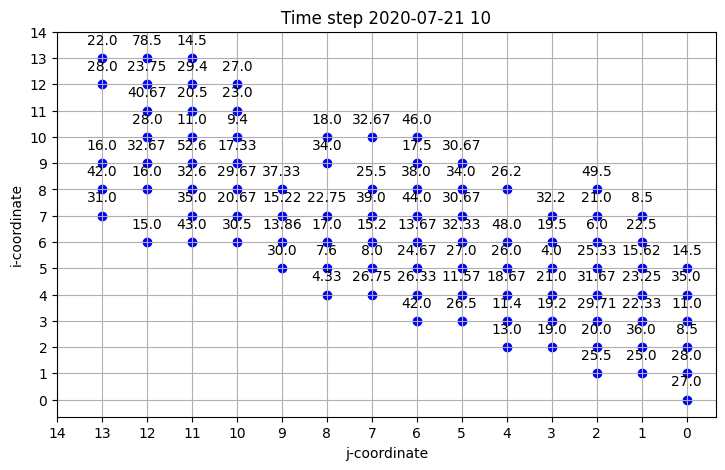

In [33]:
visualization = avg_df[avg_df['datetime_id'] == '2020-07-21 10']

plt.figure(figsize=(8.5, 5))

for _, row in visualization.iterrows():

    color = 'white' if row['speed'] < 1 else 'blue'
    color_text = 'white' if row['speed'] < 1 else 'black'

    plt.scatter(row['j'], row['i'], color=color)
    plt.annotate(str(round(row['speed'], 2)),
                 (row['j'], row['i']),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center',
                 color=color_text)

#plt.title('Ejemplo de Grilla Cartesiana para el espacio de tiempo: 2020-07-21 10')
plt.title('Time step 2020-07-21 10')
plt.xlabel('j-coordinate')
plt.ylabel('i-coordinate')
plt.gca().invert_xaxis()
plt.grid(True, which='both')
plt.xticks(list(range(15)))
plt.yticks(list(range(15)))
plt.show()

As we can see, there are positions where no data was recorded. This is because it's challenging to cover all hexagons with measurements simultaneously for every time step.

So, we need to impute the positions for all time steps where we don't have values. To achieve this, we'll first generate all possible combinations of $(i, j)$, date, and time. Then, we'll combine them with our existing data to identify which positions, dates, and times need to be imputed. Once this is done, we'll impute these missing data using the PPCA method implementation.

In [34]:
# Generating all combinations
coords_i = list(range(15))
coords_j = list(range(15))

all_coords = pd.DataFrame([(i, j) for i in coords_i for j in coords_j], columns=['i', 'j'])
unique_dates = avg_df['datetime_id'].unique()

all_combinations = pd.merge(all_coords.assign(key=1), pd.DataFrame(unique_dates, columns=['datetime_id']).assign(key=1), on='key').drop('key', axis=1)
full_df = pd.merge(all_combinations, avg_df, on=['i', 'j', 'datetime_id'], how='left').fillna(0)
full_df = full_df.sort_values(by=['datetime_id', 'i', 'j'])

# Extracting original 110 coordinates
temp_avg_df = avg_df.groupby(['i', 'j']).speed.mean().reset_index()
ori_coords = temp_avg_df[['i', 'j']]

full_df = pd.merge(full_df, ori_coords, on=['i', 'j'])

In [35]:
full_df

,i,j,datetime_id,speed
0,0,0,2020-01-04 08,33.0
1,0,0,2020-01-04 09,0.0
2,0,0,2020-01-04 10,0.0
3,0,0,2020-01-04 11,0.0
4,0,0,2020-01-04 12,0.0
...,...,...,...,...
207235,14,14,2020-07-25 15,0.0
207236,14,14,2020-07-25 16,0.0
207237,14,14,2020-07-25 17,0.0
207238,14,14,2020-07-25 18,0.0


Let's visualize our Cartesian example now

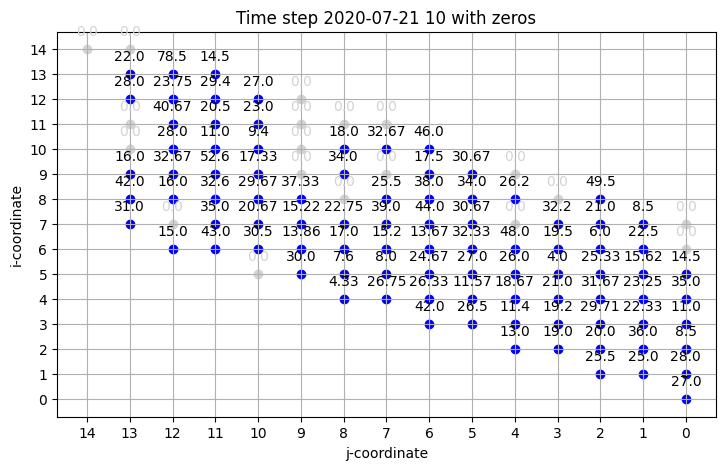

In [36]:
visualization = full_df[full_df['datetime_id'] == '2020-07-21 10']

plt.figure(figsize=(8.5, 5))

for _, row in visualization.iterrows():

    color = 'lightgray' if row['speed'] < 1 else 'blue'
    color_text = 'lightgray' if row['speed'] < 1 else 'black'

    plt.scatter(row['j'], row['i'], color=color)
    plt.annotate(str(round(row['speed'], 2)),
                 (row['j'], row['i']),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center',
                 color=color_text)

#plt.title('Ejemplo de Grilla Cartesiana para el espacio de tiempo: 2020-07-21 10')
plt.title('Time step 2020-07-21 10 with zeros')
plt.xlabel('j-coordinate')
plt.ylabel('i-coordinate')
plt.gca().invert_xaxis()
plt.grid(True, which='both')
plt.xticks(list(range(15)))
plt.yticks(list(range(15)))
plt.show()

Let's find out how many missing data we have

In [37]:
len_rows = len(full_df)

zeros = (full_df['speed'] == 0).sum()
p_zeros = (zeros / len_rows) * 100
print(f"% of missing data: {p_zeros:.2f}%")

% of missing data: 54.57%


Now, let's implement the PPCA imputation method

In [38]:
!pip install git+https://github.com/el-hult/pyppca --quiet

  Preparing metadata (setup.py) ... done


In [39]:
from pyppca import ppca

data = full_df.copy()

data[['date', 'hour']] = data['datetime_id'].str.split(' ', expand=True)
data['hour'] = data['hour'].astype(int)
data = data.drop('datetime_id', axis=1)
data = data[['date', 'hour', 'i', 'j', 'speed']]
data['date'] = pd.to_datetime(data['date'])

# Sort
data = data.sort_values(by=['date', 'hour'])

print(f"Speed std: {np.std(data['speed'])}")

data['speed'] = data['speed'].replace([0.0], np.NaN)

data['date'] = data['date'].astype('int64')
data['date'] = data['date'].div(10**9)

y = data.to_numpy()

# Generating the ppca imputation
C,ss, M, X, Ye = ppca(y,200,True)

col = data.columns
dataPCA = pd.DataFrame(Ye,columns=col)

print(dataPCA.isna().sum())

dataPCA['date'] = dataPCA['date'] * (10**9)
dataPCA['date'] = pd.to_datetime(dataPCA['date'], unit='ns')

# Adjusting the result
dataPCA['datetime_id'] = pd.to_datetime(dataPCA['date']) + pd.to_timedelta(dataPCA['hour'], unit='h')
dataPCA['datetime_id'] = dataPCA['datetime_id'].dt.strftime('%Y-%m-%d %H')
dataPCA = dataPCA.drop(columns=['date','hour'])
col_sort = ['datetime_id', 'i', 'j', 'speed']
dataPCA = dataPCA[col_sort]

np.std(dataPCA['speed'])
print(f"Speed std PCA: {np.std(dataPCA['speed'])}")

Speed std: 17.45012974429064
Objective: -inf, Relative Change nan
Objective: -inf, Relative Change nan
Objective: -inf, Relative Change nan
Objective: nan, Relative Change nan
Objective: nan, Relative Change nan
Objective: nan, Relative Change nan
Objective: nan, Relative Change nan
Objective: -inf, Relative Change nan
Objective: -inf, Relative Change nan
Objective: -inf, Relative Change nan
Objective: -inf, Relative Change nan
Objective: -inf, Relative Change nan
Objective: -inf, Relative Change nan
Objective: -inf, Relative Change nan
Objective: -inf, Relative Change nan
Objective: -inf, Relative Change nan
Objective: -inf, Relative Change nan
Objective: -inf, Relative Change nan
Objective: -inf, Relative Change nan
Objective: -inf, Relative Change nan
Objective: -inf, Relative Change nan
Objective: -inf, Relative Change nan
Objective: -inf, Relative Change nan
Objective: -inf, Relative Change nan
Objective: -inf, Relative Change nan
Objective: -inf, Relative Change nan
Objective: 67

Let's corroborate that we have inputted all the data.

In [40]:
imputed_df = dataPCA.copy()
null_values = imputed_df['speed'].isnull().sum()
zero_values = (imputed_df['speed'] == 0).sum()
print("# of null speed values:", null_values)
print("# of zero speed values:", zero_values)

# of null speed values: 0
# of zero speed values: 0


Let's see the example plot inputted.

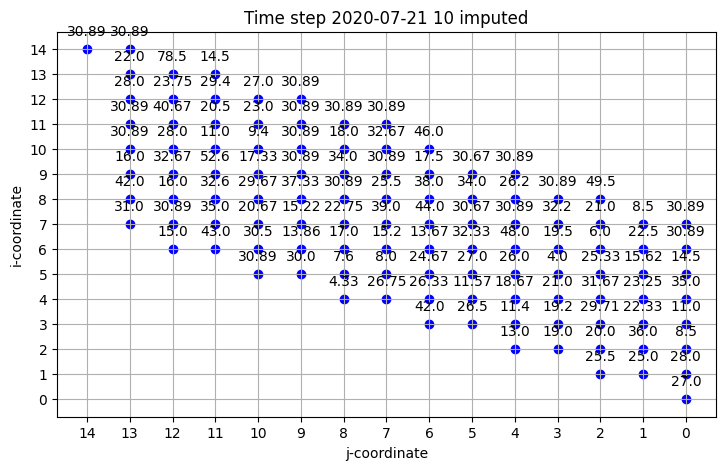

In [41]:
visualization = imputed_df[imputed_df['datetime_id'] == '2020-07-21 10']

plt.figure(figsize=(8.5, 5))

for _, row in visualization.iterrows():

    color = 'white' if row['speed'] < 1 else 'blue'
    color_text = 'white' if row['speed'] < 1 else 'black'

    plt.scatter(row['j'], row['i'], color=color)
    plt.annotate(str(round(row['speed'], 2)),
                 (row['j'], row['i']),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center',
                 color=color_text)

#plt.title('Ejemplo de Grilla Cartesiana para el espacio de tiempo: 2020-07-21 10')
plt.title('Time step 2020-07-21 10 imputed')
plt.xlabel('j-coordinate')
plt.ylabel('i-coordinate')
plt.gca().invert_xaxis()
plt.grid(True, which='both')
plt.xticks(list(range(15)))
plt.yticks(list(range(15)))
plt.show()

Now that we have inputted our grids, we can proceed to the next step: preparing our data for our hexagonal network. This preparation involves several steps. First, we will transform our grids into numpy arrays. Then, these numpy arrays will be preprocessed with upsampling, padding, and shifting matrix operations; this is necessary to preserve the original neighborhood of the hexagons when combined with the application of a hexagonal kernel. Next, we will divide our matrix tensor into training, validation, and testing sets, along with applying normalization. Finally, we will generate the sequences of time steps

First, let's transform our grids into numpy arrays.

In [42]:
# Generating the arrays
imputed_df['i'] = imputed_df['i'].astype('int64')
imputed_df['j'] = imputed_df['j'].astype('int64')

num_dates = imputed_df['datetime_id'].nunique()
max_i = int(imputed_df['i'].max()) + 1
max_j = int(imputed_df['j'].max()) + 1

array_ts = np.zeros((num_dates, max_i, max_j))

for date_idx, (date, imputed_df_group) in enumerate(imputed_df.groupby('datetime_id')):
    for _, row in imputed_df_group.iterrows():
        array_ts[date_idx, int(row['i']), int(row['j'])] = row['speed']

def flip_inver(arr):
  flipped_arr = np.flipud(arr)
  for i in range(flipped_arr.shape[0]):
      flipped_arr[i] = np.flip(flipped_arr[i])
  return flipped_arr

for idx in range(array_ts.shape[0]):
  array_ts[idx] = flip_inver(array_ts[idx])

Let's take a look at a sample of the matrix representation of our grid

In [43]:
sample = array_ts[1, :, :]
print(sample)

[[24.57 24.57  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   27.   56.   24.57  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   24.57 35.   29.17 42.   24.57  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   24.57 14.   24.57 32.5  24.57 31.   24.57  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   24.57 24.57 47.4  24.57 24.57 15.   13.   24.57  0.    0.    0.    0.    0.    0.  ]
 [ 0.   24.57 24.57 24.57 25.   24.57 24.57 12.   24.57 24.57 24.57  0.    0.    0.    0.  ]
 [ 0.   24.57 20.   68.   22.5  24.57 24.57 13.33 28.   24.57 24.57 24.57 24.57  0.    0.  ]
 [ 0.   24.57 24.57 94.   16.   24.57 19.   32.5  24.57 24.57 23.   24.57 24.57 24.57 24.57]
 [ 0.    0.   24.57 24.57 24.57 12.   20.   16.   34.   24.57 24.57 24.57 24.57 24.57 24.57]
 [ 0.    0.    0.    0.   24.57 27.   24.57 24.57 23.   24.57 24.57 24.57 24.57 24.57 24.57]
 [ 0.    0.    0.    0.    0.    0.   24.57 24.57 24.57 24.57 24.57 24

Next, let's apply the matrix operations

In [44]:
# Defining the preprocess function
def preprocess(arr):

  """
  1. Upsampling:
     With this operation, we are duplicating the rows
  """
  arr = np.expand_dims(arr, axis=0)
  arr = np.expand_dims(arr, axis=-1)

  upsampler = UpSampling2D(size=(2, 1))  # Duplicate the rows, keep the columns
  upsampled_arr = upsampler(arr)

  # Return to the original shape (height, width)
  upsampled_arr = np.squeeze(upsampled_arr)

  """
  2. Padding:
     The following padding adds 14 rows above each of our columns
  """
  padded_arr = np.pad(upsampled_arr, [(14,0),(0,0)], mode='constant')

  """
  3. Shifting:
     This operation is a custom shifting that allows us to move each column n positions downward, where n is the index of the column.
      This operation is essential to achieve the formation of the neighborhood in the (5,3) mask.
  """
  r_tup = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
  r_tup = r_tup * -1
  transposed_arr = np.transpose(padded_arr)

  m = np.asarray(r_tup)
  arr_roll = transposed_arr[:, [*range(transposed_arr.shape[1]),*range(transposed_arr.shape[1]-1)]].copy()
  strd_0, strd_1 = arr_roll.strides
  n = transposed_arr.shape[1]
  result = as_strided(arr_roll, (*transposed_arr.shape, n), (strd_0 ,strd_1, strd_1))
  shifted_arr = result[np.arange(transposed_arr.shape[0]), (n-m)%n]

  shifted_transposed_arr = np.transpose(shifted_arr)

  return shifted_transposed_arr

In [45]:
# Applying the function to each of the time steps
processed_arrs = np.zeros((array_ts.shape[0], 44, 15))

for idx in range(array_ts.shape[0]):
  processed_arrs[idx] = preprocess(array_ts[idx])

Let's take a look at a sample of the preprocessed matrix

In [46]:
processed_sample = processed_arrs[1, :, :]
print(processed_sample)

[[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0

Now that we have preprocessed our matrices, we will apply min-max scaling normalization to all our steps

In [47]:
tensor = processed_arrs.copy()

scaler = MinMaxScaler(feature_range=(0, 1))

tensor_reshaped = tensor.reshape(-1, 15)
scaled_tensor = scaler.fit_transform(tensor_reshaped)
scaled_tensor = scaled_tensor.reshape(-1, 44, 15)

Now that we have normalized our tensor, we divide it into training, validation, and testing sets.

In [48]:
train_percent = 0.7
val_percent = 0.15
test_percent = 0.15

total_examples = scaled_tensor.shape[0]
num_train_examples = int(total_examples * train_percent)
num_val_examples = int(total_examples * val_percent)
num_test_examples = total_examples - num_train_examples - num_val_examples

train_tensor = scaled_tensor[:num_train_examples]
val_tensor = scaled_tensor[num_train_examples:num_train_examples+num_val_examples]
test_tensor = scaled_tensor[num_train_examples+num_val_examples:]

# Add a final dimension of 1 channel; this is necessary to feed it into our network
train_tensor = train_tensor.reshape((train_tensor.shape[0], train_tensor.shape[1], train_tensor.shape[2], 1))
val_tensor = val_tensor.reshape((val_tensor.shape[0], val_tensor.shape[1], val_tensor.shape[2], 1))
test_tensor = test_tensor.reshape((test_tensor.shape[0], test_tensor.shape[1], test_tensor.shape[2], 1))

print(train_tensor.shape, val_tensor.shape, test_tensor.shape)

(1318, 44, 15, 1) (282, 44, 15, 1) (284, 44, 15, 1)


Now, we will generate the sequences

In [49]:
def crear_secuencias(tensor, longitud_secuencia):
    secuencias_x = []
    secuencias_y = []
    for i in range(len(tensor) - longitud_secuencia):
        secuencia_x = tensor[i:i+longitud_secuencia]
        secuencia_y = tensor[i+longitud_secuencia:i+longitud_secuencia+1]
        secuencias_x.append(secuencia_x)
        secuencias_y.append(secuencia_y)
    return np.array(secuencias_x), np.array(secuencias_y)

longitud_secuencia = 24

x_train, y_train = crear_secuencias(train_tensor, longitud_secuencia)
x_val, y_val = crear_secuencias(val_tensor, longitud_secuencia)
x_test, y_test = crear_secuencias(test_tensor, longitud_secuencia)

print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))
print("Validation Dataset Shapes: " + str(x_test.shape) + ", " + str(y_test.shape))

Training Dataset Shapes: (1294, 24, 44, 15, 1), (1294, 1, 44, 15, 1)
Validation Dataset Shapes: (258, 24, 44, 15, 1), (258, 1, 44, 15, 1)
Validation Dataset Shapes: (260, 24, 44, 15, 1), (260, 1, 44, 15, 1)


Up to this point, we have preprocessed our tensors and they are ready to be fed into our neural network. But before that, we need to define our hexagonal kernel and our network.

Let's define our hexagonal kernel

In [50]:
# Define the hexagonal kernel
class HexConstGrid5x3(tf.keras.constraints.Constraint):
    def __init__(self):
        super().__init__()

    def __call__(self, w):
        '''
        [[0, 1, 0],
         [1, 0, 1],
         [0, 1, 0],
         [1, 0, 1],
         [0, 1, 0]]
        '''
        hexaconst=np.ones(w.shape,dtype=np.float32)
        hexaconst[0,0,:,:]=0.0
        hexaconst[0,2,:,:]=0.0
        hexaconst[1,1,:,:]=0.0
        hexaconst[2,0,:,:]=0.0
        hexaconst[2,2,:,:]=0.0
        hexaconst[3,1,:,:]=0.0
        hexaconst[4,0,:,:]=0.0
        hexaconst[4,2,:,:]=0.0

        return w*hexaconst

Now, we define our HexConvLSTM network

In [51]:
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# ConvLSTM2D layer
x = layers.ConvLSTM2D(
    filters=128,
    kernel_size=(5, 3),
    padding="same",
    return_sequences=False,
    activation="relu",
    kernel_constraint=HexConstGrid5x3()
)(inp)

x = layers.BatchNormalization()(x)

# Conv2D layer
x = layers.Conv2D(
    filters=1,
    kernel_size=(3, 3),
    activation="relu",
    padding="same"
)(x)

x = layers.Reshape((1,44,15,1))(x)

In [52]:
# Building the complete model
model = keras.models.Model(inp, x)
model.compile(
    loss='mse',
    optimizer=keras.optimizers.Adam()
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 44, 15, 1   0         
                             )]                                  
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 44, 15, 128)       991232    
                                                                 
 batch_normalization (Batch  (None, 44, 15, 128)       512       
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 44, 15, 1)         1153      
                                                                 
 reshape (Reshape)           (None, 1, 44, 15, 1)      0         
                                                                 
Total params: 992897 (3.79 MB)
Trainable params: 992641 (3.79

Now that we have our network defined, let's train it.

In [53]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 500
batch_size = 64

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/500
21/21 [==============================] - 20s 537ms/step - loss: 0.0095 - val_loss: 0.0365 - lr: 0.0010
Epoch 2/500
21/21 [==============================] - 11s 507ms/step - loss: 0.0029 - val_loss: 0.0365 - lr: 0.0010
Epoch 3/500
21/21 [==============================] - 11s 506ms/step - loss: 0.0027 - val_loss: 0.0365 - lr: 0.0010
Epoch 4/500
21/21 [==============================] - 11s 508ms/step - loss: 0.0027 - val_loss: 0.0364 - lr: 0.0010
Epoch 5/500
21/21 [==============================] - 11s 504ms/step - loss: 0.0026 - val_loss: 0.0363 - lr: 0.0010
Epoch 6/500
21/21 [==============================] - 11s 505ms/step - loss: 0.0026 - val_loss: 0.0362 - lr: 0.0010
Epoch 7/500
21/21 [==============================] - 11s 505ms/step - loss: 0.0026 - val_loss: 0.0361 - lr: 0.0010
Epoch 8/500
21/21 [==============================] - 11s 506ms/step - loss: 0.0026 - val_loss: 0.0359 - lr: 0.0010
Epoch 9/500
21/21 [==============================] - 11s 505ms/step - loss: 0.00

Let's plot the loss

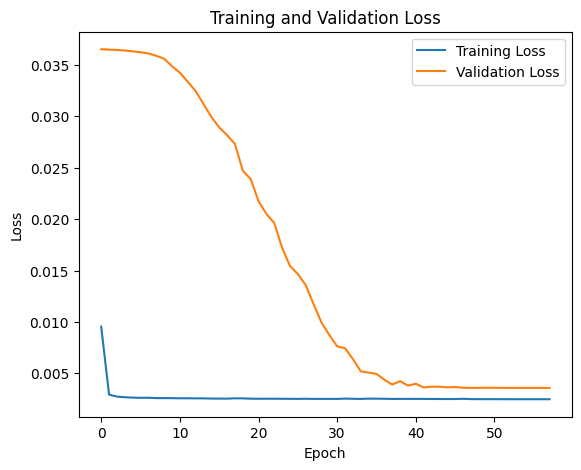

In [54]:
history = model.history.history

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

Now, let's generate the evaluation metrics for the dimensions 44x15, 15x15, and the 110 coordinates.

In [55]:
train_prediction = model.predict(x_train)
train_prediction.shape

train_prediction_reshaped = train_prediction.reshape(-1, 15)
train_prediction_original_scale = scaler.inverse_transform(train_prediction_reshaped)
train_prediction_original_scale = train_prediction_original_scale.reshape(-1, 44, 15)

y_train_reshaped = y_train.reshape(-1, 15)
y_train_original_scale = scaler.inverse_transform(y_train_reshaped)
y_train_original_scale = y_train_original_scale.reshape(-1, 44, 15)

val_prediction = model.predict(x_val)

val_prediction_reshaped = val_prediction.reshape(-1, 15)
val_prediction_original_scale = scaler.inverse_transform(val_prediction_reshaped)
val_prediction_original_scale = val_prediction_original_scale.reshape(-1, 44, 15)

y_val_reshaped = y_val.reshape(-1, 15)
y_val_original_scale = scaler.inverse_transform(y_val_reshaped)
y_val_original_scale = y_val_original_scale.reshape(-1, 44, 15)

test_prediction = model.predict(x_test)

test_prediction_reshaped = test_prediction.reshape(-1, 15)
test_prediction_original_scale = scaler.inverse_transform(test_prediction_reshaped)
test_prediction_original_scale = test_prediction_original_scale.reshape(-1, 44, 15)

y_test_reshaped = y_test.reshape(-1, 15)
y_test_original_scale = scaler.inverse_transform(y_test_reshaped)
y_test_original_scale = y_test_original_scale.reshape(-1, 44, 15)

9/9 [==============================] - 1s 99ms/step


In [56]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calcular_metricas_3d(original_tensor, prediccion_tensor):

    sum_mae, sum_mse, sum_rmse, sum_r2 = 0, 0, 0, 0

    for i in range(original_tensor.shape[0]):
        mae = mean_absolute_error(original_tensor[i], prediccion_tensor[i])
        mse = mean_squared_error(original_tensor[i], prediccion_tensor[i])
        rmse = np.sqrt(mse)
        r2 = r2_score(original_tensor[i].flatten(), prediccion_tensor[i].flatten())

        sum_mae += mae
        sum_mse += mse
        sum_rmse += rmse
        sum_r2 += r2

    avg_mae = sum_mae / original_tensor.shape[0]
    avg_mse = sum_mse / original_tensor.shape[0]
    avg_rmse = sum_rmse / original_tensor.shape[0]
    avg_r2 = sum_r2 / original_tensor.shape[0]

    return avg_mae, avg_mse, avg_rmse, avg_r2

Metrics for 44x15

In [57]:
mae, mse, rmse, r2 = calcular_metricas_3d(y_train_original_scale, train_prediction_original_scale)

print("Training:")
print(f"Average MAE: {mae:.3f}")
print(f"Average MSE: {mse:.3f}")
print(f"Average RMSE: {rmse:.3f}")
print(f"Average R^2: {r2:.3f}")
print("")

mae, mse, rmse, r2 = calcular_metricas_3d(y_val_original_scale, val_prediction_original_scale)

print("Validation:")
print(f"Average MAE: {mae:.3f}")
print(f"Average MSE: {mse:.3f}")
print(f"Average RMSE: {rmse:.3f}")
print(f"Average R^2: {r2:.3f}")
print("")

mae, mse, rmse, r2 = calcular_metricas_3d(y_test_original_scale, test_prediction_original_scale)

print("Test:")
print(f"Average MAE: {mae:.3f}")
print(f"Average MSE: {mse:.3f}")
print(f"Average RMSE: {rmse:.3f}")
print(f"Average R^2: {r2:.3f}")
print("")

Training:
Average MAE: 1.845
Average MSE: 28.815
Average RMSE: 5.237
Average R^2: 0.854

Validation:
Average MAE: 2.400
Average MSE: 40.495
Average RMSE: 6.293
Average R^2: 0.835

Test:
Average MAE: 2.463
Average MSE: 40.348
Average RMSE: 6.284
Average R^2: 0.836



Metrics for 15x15

In [58]:
def postprocess(arr):
  unshifted_matrix = np.empty_like(arr)
  for i in range(arr.shape[1]):
      n = i
      unshifted_matrix[:, i] = np.concatenate((arr[-n:, i], arr[:-n, i]))

  unpadded_matrix = unshifted_matrix[14:, :]
  downsampled_matrix = unpadded_matrix[::2]

  return downsampled_matrix

# Training:
# Postprocess originals
postprocessed_originals_train = []
for i in range(y_train_original_scale.shape[0]):
    postprocessed_matrix = postprocess(y_train_original_scale[i])
    postprocessed_originals_train.append(postprocessed_matrix)
postprocessed_original_arr_train = np.array(postprocessed_originals_train)

# Postprocess predictions
postprocessed_predictions_train = []
for i in range(train_prediction_original_scale.shape[0]):
    postprocessed_matrix = postprocess(train_prediction_original_scale[i])
    postprocessed_predictions_train.append(postprocessed_matrix)

postprocessed_predictions_arr_train = np.array(postprocessed_predictions_train)

# Validation:
# Postprocess originals
postprocessed_originals_val = []
for i in range(y_val_original_scale.shape[0]):
    postprocessed_matrix = postprocess(y_val_original_scale[i])
    postprocessed_originals_val.append(postprocessed_matrix)
postprocessed_original_arr_val = np.array(postprocessed_originals_val)

# Postprocess predictions
postprocessed_predictions_val = []
for i in range(val_prediction_original_scale.shape[0]):
    postprocessed_matrix = postprocess(val_prediction_original_scale[i])
    postprocessed_predictions_val.append(postprocessed_matrix)

postprocessed_predictions_arr_val = np.array(postprocessed_predictions_val)

# Testing:
# Postprocess originals
postprocessed_originals_test = []
for i in range(y_test_original_scale.shape[0]):
    postprocessed_matrix = postprocess(y_test_original_scale[i])
    postprocessed_originals_test.append(postprocessed_matrix)
postprocessed_original_arr_test = np.array(postprocessed_originals_test)

# Postprocess predictions
postprocessed_predictions_test = []
for i in range(test_prediction_original_scale.shape[0]):
    postprocessed_matrix = postprocess(test_prediction_original_scale[i])
    postprocessed_predictions_test.append(postprocessed_matrix)

postprocessed_predictions_arr_test = np.array(postprocessed_predictions_test)

# Calcular las métricas promedio
mae, mse, rmse, r2 = calcular_metricas_3d(postprocessed_original_arr_train, postprocessed_predictions_arr_train)

print("Training:")
print(f"Average MAE: {mae:.3f}")
print(f"Average MSE: {mse:.3f}")
print(f"Average RMSE: {rmse:.3f}")
print(f"Average R^2: {r2:.3f}")
print("")

mae, mse, rmse, r2 = calcular_metricas_3d(postprocessed_original_arr_val, postprocessed_predictions_arr_val)

print("Validation:")
print(f"Average MAE: {mae:.3f}")
print(f"Average MSE: {mse:.3f}")
print(f"Average RMSE: {rmse:.3f}")
print(f"Average R^2: {r2:.3f}")
print("")

mae, mse, rmse, r2 = calcular_metricas_3d(postprocessed_original_arr_test, postprocessed_predictions_arr_test)

print("Test:")
print(f"Average MAE: {mae:.3f}")
print(f"Average MSE: {mse:.3f}")
print(f"Average RMSE: {rmse:.3f}")
print(f"Average R^2: {r2:.3f}")
print("")

Training:
Average MAE: 2.704
Average MSE: 42.237
Average RMSE: 6.339
Average R^2: 0.819

Validation:
Average MAE: 3.516
Average MSE: 59.389
Average RMSE: 7.620
Average R^2: 0.797

Test:
Average MAE: 3.615
Average MSE: 59.245
Average RMSE: 7.614
Average R^2: 0.798



Metrics for 110 coordinates

In [59]:
# We convert the data into dataframes and combine actual vs. predictions
def array_to_dataframe(arr):
    ids = []
    is_list = []
    js_list = []
    velocidades = []

    for id in range(arr.shape[0]):
        for i in range(arr.shape[1]):
            for j in range(arr.shape[2]):
                ids.append(id)
                is_list.append(i)
                js_list.append(j)
                velocidades.append(arr[id, i, j])

    df = pd.DataFrame({
        'id': ids,
        'i': is_list,
        'j': js_list,
        'speed': velocidades
    })

    return df

# Training:
df_actuals_train = array_to_dataframe(postprocessed_original_arr_train)
df_preds_train = array_to_dataframe(postprocessed_predictions_arr_train)

df_original_train = df_actuals_train.rename(columns={'speed': 'speed_actual'})
df_predictions_train = df_preds_train.rename(columns={'speed': 'speed_predicted'})

df_results_train = pd.merge(df_original_train, df_predictions_train, on=['id','i', 'j'], how='inner')
# ----------------------------#

# Validation:
df_actuals_val = array_to_dataframe(postprocessed_original_arr_val)
df_preds_val = array_to_dataframe(postprocessed_predictions_arr_val)

df_original_val = df_actuals_val.rename(columns={'speed': 'speed_actual'})
df_predictions_val = df_preds_val.rename(columns={'speed': 'speed_predicted'})

df_results_val = pd.merge(df_original_val, df_predictions_val, on=['id','i', 'j'], how='inner')
# ----------------------------#

# Test:
df_actuals_test = array_to_dataframe(postprocessed_original_arr_test)
df_preds_test = array_to_dataframe(postprocessed_predictions_arr_test)

df_original_test = df_actuals_test.rename(columns={'speed': 'speed_actual'})
df_predictions_test = df_preds_test.rename(columns={'speed': 'speed_predicted'})

df_results_test = pd.merge(df_original_test, df_predictions_test, on=['id','i', 'j'], how='inner')
# ----------------------------#


results_110_train = pd.merge(ori_coords, df_results_train, on=['i','j'])
results_110_val = pd.merge(ori_coords, df_results_val, on=['i','j'])
results_110_test = pd.merge(ori_coords, df_results_test, on=['i','j'])

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

def calculate_metrics(df):
    y_true = df['speed_actual']
    y_pred = df['speed_predicted']

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    maaape = np.mean(np.arctan(np.abs((y_true - y_pred) / y_true))) * 100

    return mae, mse, rmse, r2, mape, smape, maaape


mae, mse, rmse, r2, mape, smape, maaape = calculate_metrics(results_110_train)

print("Training:")
print("----------")
print(f"Average MAE: {mae:.3f}")
print(f"Average MSE: {mse:.3f}")
print(f"Average RMSE: {rmse:.3f}")
print(f"Average R^2: {r2:.3f}")
print(f"Average MAPE: {mape:.3f}")
print(f"Average SMAPE: {smape:.3f}")
print(f"Average MAAPE: {maaape:.3f}")
print("")

mae, mse, rmse, r2, mape, smape, maaape = calculate_metrics(results_110_val)

print("Validation:")
print("----------")
print(f"Average MAE: {mae:.3f}")
print(f"Average MSE: {mse:.3f}")
print(f"Average RMSE: {rmse:.3f}")
print(f"Average R^2: {r2:.3f}")
print(f"Average MAPE: {mape:.3f}")
print(f"Average SMAPE: {smape:.3f}")
print(f"Average MAAPE: {maaape:.3f}")
print("")

mae, mse, rmse, r2, mape, smape, maaape = calculate_metrics(results_110_test)

print("Testing:")
print("----------")
print(f"Average MAE: {mae:.3f}")
print(f"Average MSE: {mse:.3f}")
print(f"Average RMSE: {rmse:.3f}")
print(f"Average R^2: {r2:.3f}")
print(f"Average MAPE: {mape:.3f}")
print(f"Average SMAPE: {smape:.3f}")
print(f"Average MAAPE: {maaape:.3f}")
print("")

Training:
----------
Average MAE: 5.362
Average MSE: 84.684
Average RMSE: 9.202
Average R^2: 0.484
Average MAPE: inf
Average SMAPE: 23.453
Average MAAPE: 23.245

Validation:
----------
Average MAE: 6.937
Average MSE: 118.743
Average RMSE: 10.897
Average R^2: 0.458
Average MAPE: inf
Average SMAPE: 28.387
Average MAAPE: 27.897

Testing:
----------
Average MAE: 7.087
Average MSE: 118.200
Average RMSE: 10.872
Average R^2: 0.464
Average MAPE: inf
Average SMAPE: 29.188
Average MAAPE: 28.872

